Copyright (c) 2019 [윤기태]

https://github.com/yoonkt200/python-data-analysis

[MIT License](https://github.com/yoonkt200/python-data-analysis/blob/master/LICENSE.txt)

# (가제) 파이썬 데이터 분석

-----

# 2.1) 목표 예측을 위한 회귀분석

### 바로가기

- [1. Housing 데이터 살펴보기](#1.-Housing-데이터-살펴보기)
    - [Housing 데이터셋의 기본 정보]
    - [회귀 분석에 사용할 피처 살펴보기]
- [2. 보스턴의 집값 예측하기](#2.-보스턴의-집값-예측하기)
    - [피처들의 단위 맞춰주기 : 피처 스케일링]
    - [변수들의 상관관계 분석]
    - [회귀 분석 적용하기]
- [3. 예측 모델을 평가해보자](#3.-예측-모델을-평가해보자)
    - [어떤 피처가 가장 유의미한 변수일까]
    - [예측 모델의 평가]
    - [회귀 분석 예측 성능을 높이기 위한 방법 : 다중 공선성 확인]
    - [믿을만한 변수로 다시 학습하기]
- [4. 분석 결과의 시각화](#4.-분석-결과의-시각화)
    - [지도로 살펴보는 보스턴의 housing price]

-----

In [1]:
# -*- coding: utf-8 -*-

%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

# 1. Housing 데이터 살펴보기

### [Housing 데이터셋의 기본 정보]

###### 데이터 피처 설명
- TOWN : 지역 이름
- LON, LAT : 위도, 경도 정보
- CMEDV : 해당 지역의 집값(중간값)
- CRIM : 지역 범죄율
- ZN : 주택지 비율
- INDUS : 상업적 비즈니스에 활용되지 않는 농지 면적
- CHAS : 경계선에 강에 있는지 여부
- NOX : 산화 질소 농도
- RM : 자택당 평균 방 갯수
- AGE : 1940 년 이전에 건설된 비율
- DIS : 5 개의 보스턴 고용 센터와의 거리에 다른 가중치 부여
- RAD : radial 고속도로와의 접근성 지수
- TAX : 10000달러당 재산세
- PTRATIO : 지역별 학생-교사 비율
- B : 지역의 흑인 지수 (1000(B - 0.63)^2), B는 흑인의 비율.
- LSTAT : 빈곤층의 비율

In [2]:
# Data Source : http://lib.stat.cmu.edu/datasets/boston_corrected.txt

file_path = '../data/BostonHousing2.csv'
housing = pd.read_csv(file_path)

In [3]:
housing.head()

,TOWN,LON,LAT,CMEDV,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,Nahant,-70.955,42.2550,24.0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98
1,Swampscott,-70.950,42.2875,21.6,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14
2,Swampscott,-70.936,42.2830,34.7,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03
3,Marblehead,-70.928,42.2930,33.4,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94
4,Marblehead,-70.922,42.2980,36.2,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33


In [4]:
print(housing.shape)
print("------------------------------------")
print(housing.info())
print("------------------------------------")
print(housing.columns)

(506, 17)
------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 17 columns):
TOWN       506 non-null object
LON        506 non-null float64
LAT        506 non-null float64
CMEDV      506 non-null float64
CRIM       506 non-null float64
ZN         506 non-null float64
INDUS      506 non-null float64
CHAS       506 non-null int64
NOX        506 non-null float64
RM         506 non-null float64
AGE        506 non-null float64
DIS        506 non-null float64
RAD        506 non-null int64
TAX        506 non-null int64
PTRATIO    506 non-null float64
B          506 non-null float64
LSTAT      506 non-null float64
dtypes: float64(13), int64(3), object(1)
memory usage: 67.3+ KB
None
------------------------------------
Index(['TOWN', 'LON', 'LAT', 'CMEDV', 'CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX',
       'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT'],
      dtype='object')


-----

###### 예측해야 할 수치인 '집값'에 대한 정보

In [5]:
housing['CMEDV'].describe()

count    506.000000
mean      22.528854
std        9.182176
min        5.000000
25%       17.025000
50%       21.200000
75%       25.000000
max       50.000000
Name: CMEDV, dtype: float64

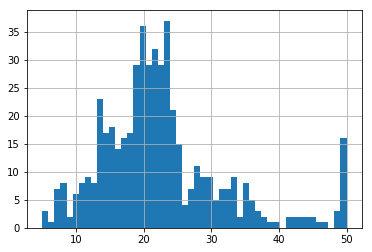

In [6]:
housing['CMEDV'].hist(bins=50) # 보스턴 집값의 분포

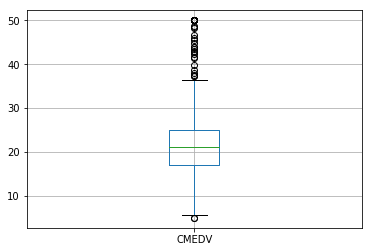

In [7]:
housing.boxplot(column=['CMEDV']) # 보스턴 집값의 Boxplot

-----

### [회귀 분석에 사용할 피처 살펴보기]

In [8]:
housing_features_df = housing[['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 
                            'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'CMEDV']]

In [9]:
# 피처 각각에 대한 histogram을 그려줍니다.
def plot_hist_each_column(df):
    plt.rcParams['figure.figsize'] = [20, 16]
    fig = plt.figure(1)
    for i in range(len(df.columns)):
        ax = fig.add_subplot(4, 4, i+1)
        plt.hist(df[df.columns[i]], bins=50)
        ax.set_title(df.columns[i])
    plt.show()

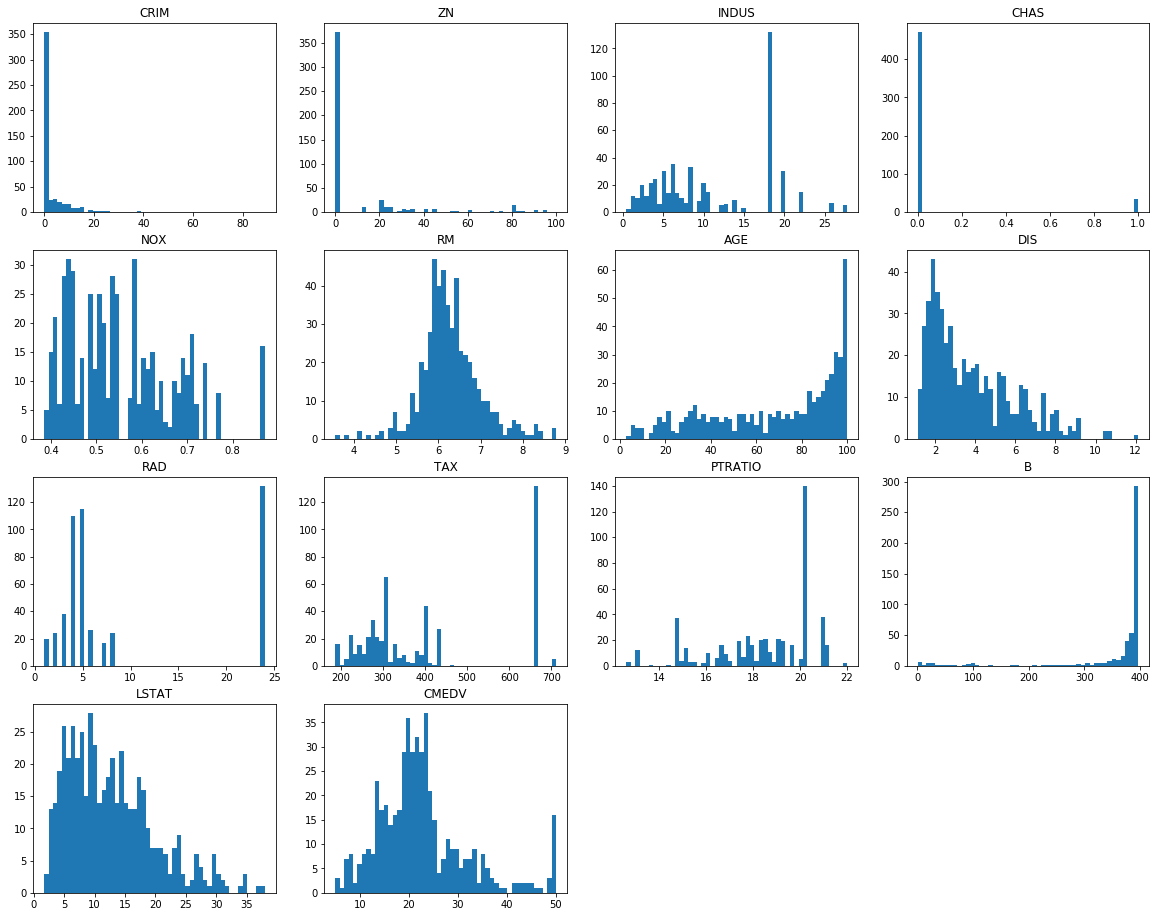

In [10]:
plot_hist_each_column(housing_features_df)

-----

# 2. 보스턴의 집값 예측하기

### [피처들의 단위 맞춰주기 : 피처 스케일링]

In [11]:
# pandas 형태로 정의된 데이터를 출력할 때, scientific-notation이 아닌 float 모양으로 출력되게 해줍니다.
pd.options.mode.chained_assignment = None

In [12]:
# 피처 각각에 대한 scaling을 수행합니다.
def standard_scaling(df, scale_columns):
    for col in scale_columns:
        series_mean = df[col].mean()
        series_std = df[col].std()
        df[col] = df[col].apply(lambda x: (x-series_mean)/series_std)
    return df

In [13]:
scale_columns = ['CRIM', 'ZN', 'INDUS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']
scaled_housing_df = standard_scaling(housing_features_df, scale_columns)

In [14]:
scaled_housing_df = scaled_housing_df.rename(columns={'CMEDV': 'y'})
scaled_housing_df.head(10)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,y
0,-0.419367,0.284548,-1.286636,0,-0.144075,0.413263,-0.119895,0.140075,-0.981871,-0.665949,-1.457558,0.440616,-1.074499,24.0
1,-0.416927,-0.487240,-0.592794,0,-0.739530,0.194082,0.366803,0.556609,-0.867024,-0.986353,-0.302794,0.440616,-0.491953,21.6
2,-0.416929,-0.487240,-0.592794,0,-0.739530,1.281446,-0.265549,0.556609,-0.867024,-0.986353,-0.302794,0.396035,-1.207532,34.7
3,-0.416338,-0.487240,-1.305586,0,-0.834458,1.015298,-0.809088,1.076671,-0.752178,-1.105022,0.112920,0.415751,-1.360171,33.4
4,-0.412074,-0.487240,-1.305586,0,-0.834458,1.227362,-0.510674,1.076671,-0.752178,-1.105022,0.112920,0.440616,-1.025487,36.2
5,-0.416631,-0.487240,-1.305586,0,-0.834458,0.206892,-0.350810,1.076671,-0.752178,-1.105022,0.112920,0.410165,-1.042291,28.7
6,-0.409837,0.048724,-0.476182,0,-0.264892,-0.388027,-0.070159,0.838414,-0.522484,-0.576948,-1.503749,0.426376,-0.031237,22.9
7,-0.403297,0.048724,-0.476182,0,-0.264892,-0.160307,0.977841,1.023625,-0.522484,-0.576948,-1.503749,0.440616,0.909800,22.1
8,-0.395543,0.048724,-0.476182,0,-0.264892,-0.930285,1.116390,1.086122,-0.522484,-0.576948,-1.503749,0.328123,2.419379,16.5
9,-0.400333,0.048724,-0.476182,0,-0.264892,-0.399413,0.615481,1.328320,-0.522484,-0.576948,-1.503749,0.329000,0.622728,18.9


-----

### [변수들의 상관관계 분석]

In [15]:
# 변수간의 상관계수 행렬 구하기
cols = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']
corr = scaled_housing_df[cols].corr(method = 'pearson')
print(corr)

             CRIM        ZN     INDUS      CHAS       NOX        RM       AGE  \
CRIM     1.000000 -0.200469  0.406583 -0.055892  0.420972 -0.219247  0.352734   
ZN      -0.200469  1.000000 -0.533828 -0.042697 -0.516604  0.311991 -0.569537   
INDUS    0.406583 -0.533828  1.000000  0.062938  0.763651 -0.391676  0.644779   
CHAS    -0.055892 -0.042697  0.062938  1.000000  0.091203  0.091251  0.086518   
NOX      0.420972 -0.516604  0.763651  0.091203  1.000000 -0.302188  0.731470   
RM      -0.219247  0.311991 -0.391676  0.091251 -0.302188  1.000000 -0.240265   
AGE      0.352734 -0.569537  0.644779  0.086518  0.731470 -0.240265  1.000000   
DIS     -0.379670  0.664408 -0.708027 -0.099176 -0.769230  0.205246 -0.747881   
RAD      0.625505 -0.311948  0.595129 -0.007368  0.611441 -0.209847  0.456022   
TAX      0.582764 -0.314563  0.720760 -0.035587  0.668023 -0.292048  0.506456   
PTRATIO  0.289946 -0.391679  0.383248 -0.121515  0.188933 -0.355501  0.261515   
B       -0.385064  0.175520 

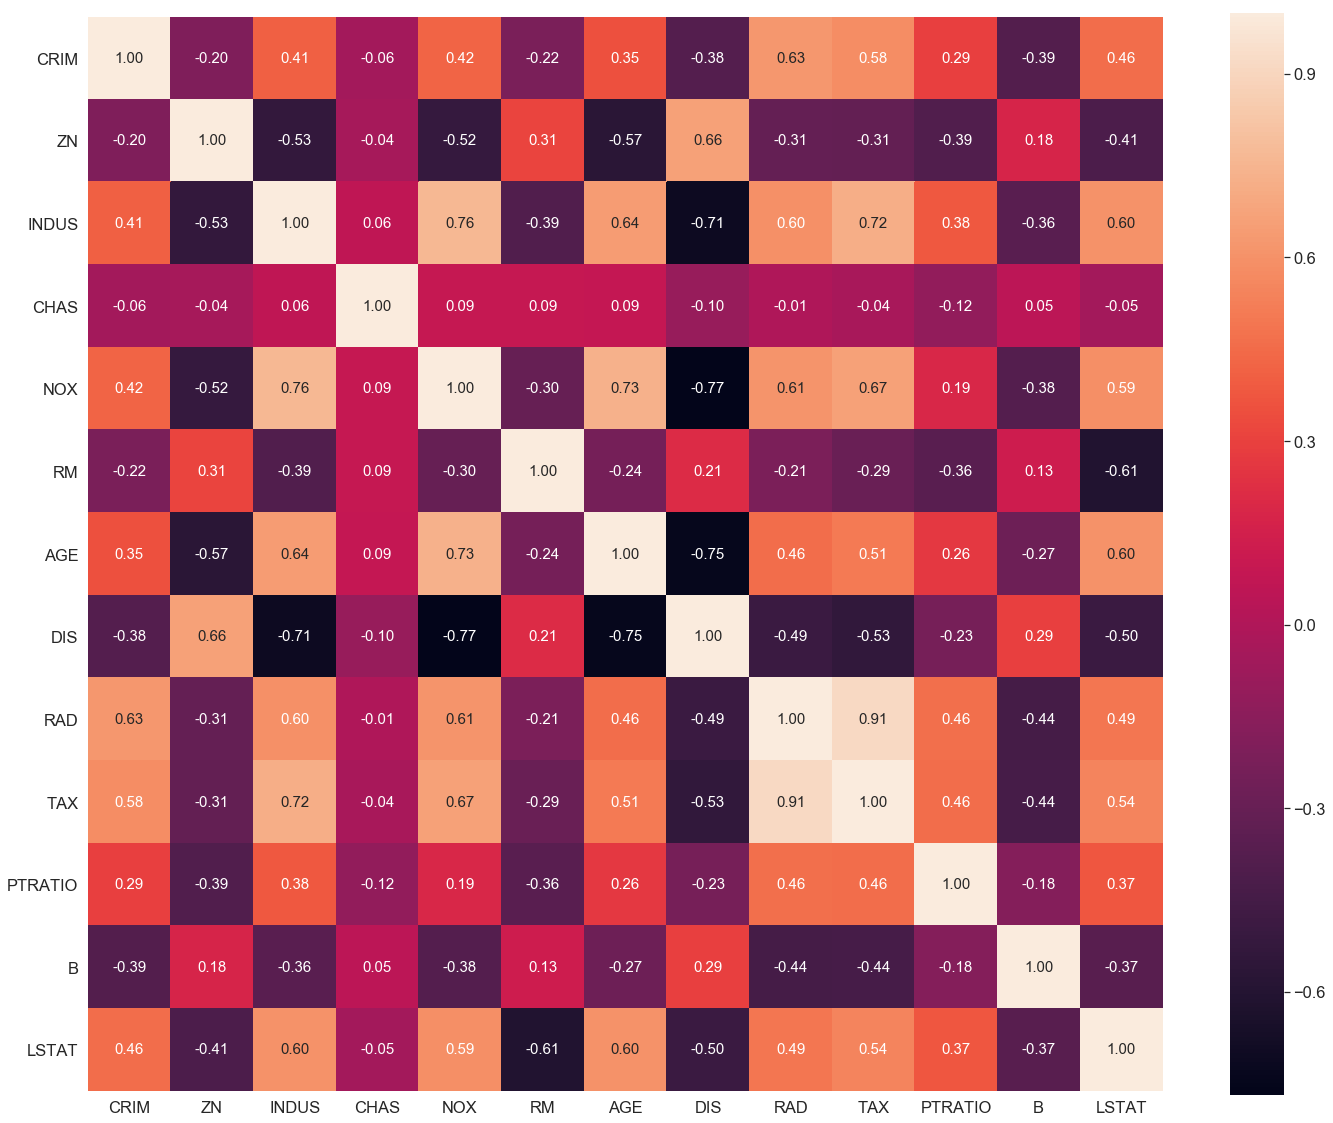

In [16]:
import seaborn as sns

# corr 행렬 히트맵 시각화
cols_view = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']
sns.set(font_scale=1.5)
hm = sns.heatmap(corr.values,
            cbar=True,
            annot=True, 
            square=True,
            fmt='.2f',
            annot_kws={'size': 15},
            yticklabels=cols_view,
            xticklabels=cols_view)

plt.tight_layout()
plt.show()

- (indus, nox, age), (rad, tax) 두 조합이 비슷한 역할을 하는 피처인것으로 추정됩니다.

-----

### [회귀 분석 적용하기]

In [17]:
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt

X = scaled_housing_df[['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 
                       'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']]
y = scaled_housing_df['y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=33)

In [18]:
lr = linear_model.LinearRegression()
model = lr.fit(X_train, y_train) # 모델 학습

-----

# 3. 예측 모델을 평가해보자

### [어떤 피처가 가장 유의미한 변수일까]

In [19]:
print(lr.coef_) # 각 변수별 계수 출력

[-0.95643634  1.18808119  0.22326069  3.02115825 -1.78577413  2.84272496
 -0.05562082 -3.28731689  2.84761095 -2.33972039 -1.77991349  0.79851917
 -4.17795131]


In [20]:
import statsmodels.api as sm

X_train = sm.add_constant(X_train)
model = sm.OLS(y_train, X_train).fit()

model.summary()

ModuleNotFoundError: No module named 'statsmodels'

[Text(0, 0, 'CRIM'),
 Text(0, 0, 'ZN'),
 Text(0, 0, 'INDUS'),
 Text(0, 0, 'CHAS'),
 Text(0, 0, 'NOX'),
 Text(0, 0, 'RM'),
 Text(0, 0, 'AGE'),
 Text(0, 0, 'DIS'),
 Text(0, 0, 'RAD'),
 Text(0, 0, 'TAX'),
 Text(0, 0, 'PTRATIO'),
 Text(0, 0, 'B'),
 Text(0, 0, 'LSTAT')]

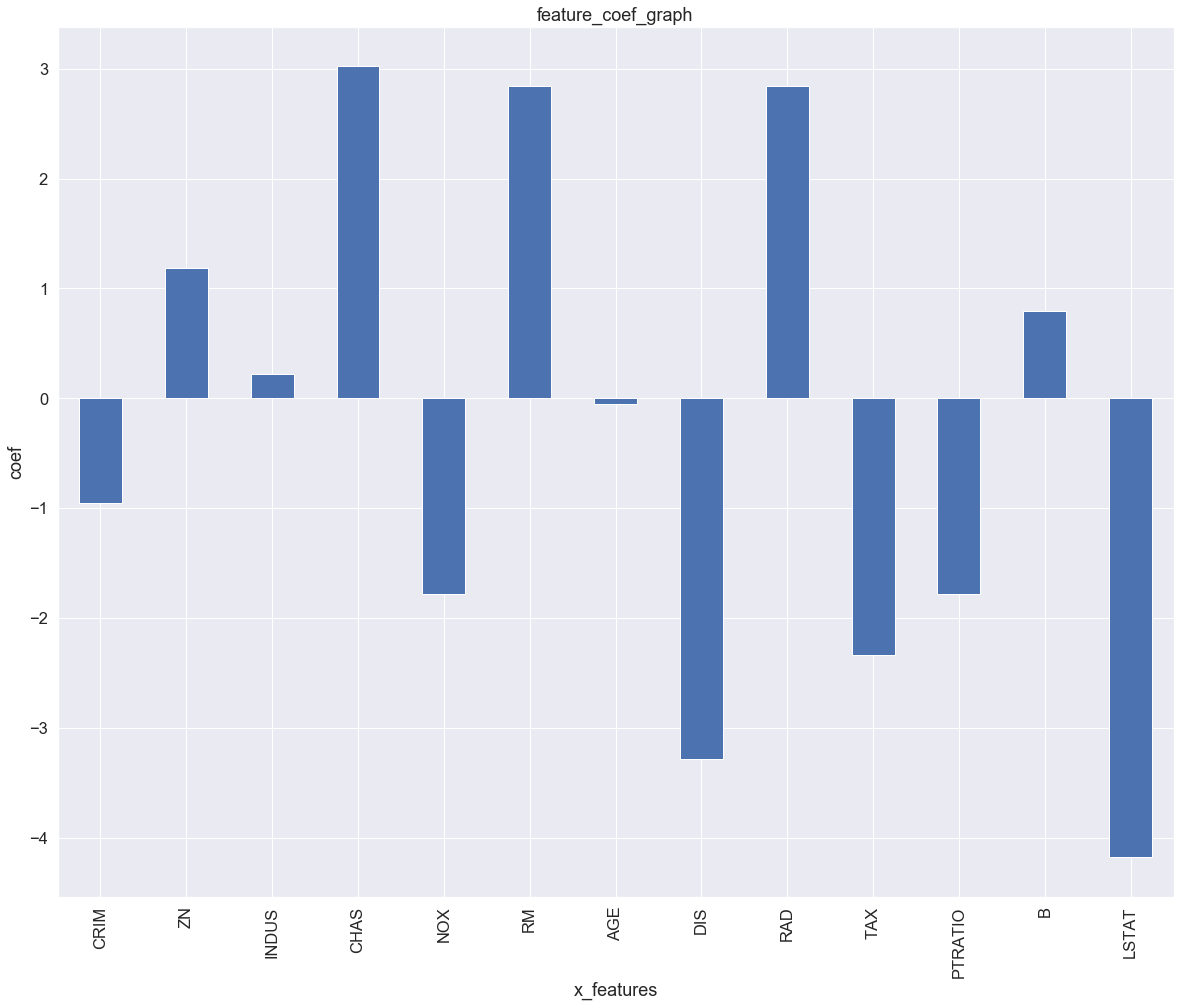

In [21]:
plt.rcParams['figure.figsize'] = [20, 16]

coefs = lr.coef_.tolist()
coefs_series = pd.Series(coefs)

x_labels = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']

ax = coefs_series.plot(kind='bar')
ax.set_title('feature_coef_graph')
ax.set_xlabel('x_features')
ax.set_ylabel('coef')
ax.set_xticklabels(x_labels)

-----

### [예측 모델의 평가]

In [22]:
X = scaled_housing_df[['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 
                       'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']]
y = scaled_housing_df['y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=33)

In [23]:
lr = linear_model.LinearRegression()
model = lr.fit(X_train, y_train) # 모델 학습

In [24]:
print(model.score(X_train, y_train)) # train R2 score
print(model.score(X_test, y_test)) # test R2 score

0.7490284664199387
0.700934213532155


In [25]:
y_predictions = lr.predict(X_train)
print(sqrt(mean_squared_error(y_train, y_predictions))) # train RMSE score

y_predictions = lr.predict(X_test)
print(sqrt(mean_squared_error(y_test, y_predictions))) # test RMSE score

4.672162734008588
4.61495178491331


-----

### [회귀분석 예측 성능을 높이기 위한 방법 : 다중공선성 확인]

In [26]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [27]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns

In [28]:
vif.round(1)

,VIF Factor,features
0,1.8,CRIM
1,2.3,ZN
2,4.0,INDUS
3,1.1,CHAS
4,4.4,NOX
5,1.9,RM
6,3.1,AGE
7,4.0,DIS
8,7.5,RAD
9,9.0,TAX


-----

### [믿을만한 변수로 다시 학습하기]

In [29]:
X = scaled_housing_df[['CRIM', 'ZN', 'CHAS', 'NOX', 
                       'RM', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']]
y = scaled_housing_df['y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=33)

In [30]:
lr = linear_model.LinearRegression()
model = lr.fit(X_train, y_train) # 모델 학습

In [31]:
print(model.score(X_train, y_train)) # train R2 score
print(model.score(X_test, y_test)) # test R2 score

0.7488676412541904
0.7016523248519185


In [32]:
y_predictions = lr.predict(X_train)
print(sqrt(mean_squared_error(y_train, y_predictions))) # train RMSE score

y_predictions = lr.predict(X_test)
print(sqrt(mean_squared_error(y_test, y_predictions))) # test RMSE score

4.673659479471092
4.609407785787353


-----

# 4. 분석 결과의 시각화

### [지도로 살펴보는 보스턴의 housing price]

In [33]:
# 위치 정보를 추가하기 위한 데이터 전처리
X = scaled_housing_df[['CRIM', 'ZN', 'CHAS', 'NOX', 
                       'RM', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']]
X['LON'] = housing['LON']
X['LAT'] = housing['LAT']
y = scaled_housing_df['y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=33)
X_train = X_train.drop(['LON', 'LAT'], axis=1)

In [34]:
# 위치 정보를 추가한 테스트 데이터셋 생성하기
lr = linear_model.LinearRegression()
model = lr.fit(X_train, y_train)
y_predictions = lr.predict(X_test.drop(['LON', 'LAT'], axis=1))
X_test['CMEDV'] = y_test
X_test = X_test.reset_index(drop=True)
X_test['y_pred'] = pd.Series(y_predictions)

In [35]:
X_test.head(5)

,CRIM,ZN,CHAS,NOX,RM,DIS,RAD,TAX,PTRATIO,B,LSTAT,LON,LAT,CMEDV,y_pred
0,-0.409291,-0.48724,0,0.227006,-0.460613,-0.811196,-0.867024,-1.306758,0.297683,0.234580,0.738957,-71.0377,42.2470,20.5,20.111451
1,2.491712,-0.48724,0,1.193543,-0.423608,-1.047743,1.659603,1.529413,0.805778,0.440616,1.976868,-71.0326,42.2011,5.6,11.403538
2,0.399567,-0.48724,0,0.511789,-0.258511,-0.842111,1.659603,1.529413,0.805778,-3.879233,1.489546,-71.0619,42.1948,13.4,12.992794
3,0.733743,-0.48724,0,1.599143,-0.047870,-0.758434,1.659603,1.529413,0.805778,0.348825,0.530304,-71.0370,42.1840,12.6,18.462443
4,-0.405838,-0.48724,0,-0.920756,-0.306902,0.914588,-0.752178,-1.039754,-0.256604,0.358355,-0.434538,-70.9675,42.3170,21.2,22.547469


In [36]:
# 지도의 기준이 되는 좌표들을 정의
lon_min, lon_max = -71.45, -70.55
lat_min, lat_max = 42, 42.6

-----

- 실제 집값과 예측 집값을 컬러맵 형식의 그래프로 시각화합니다.

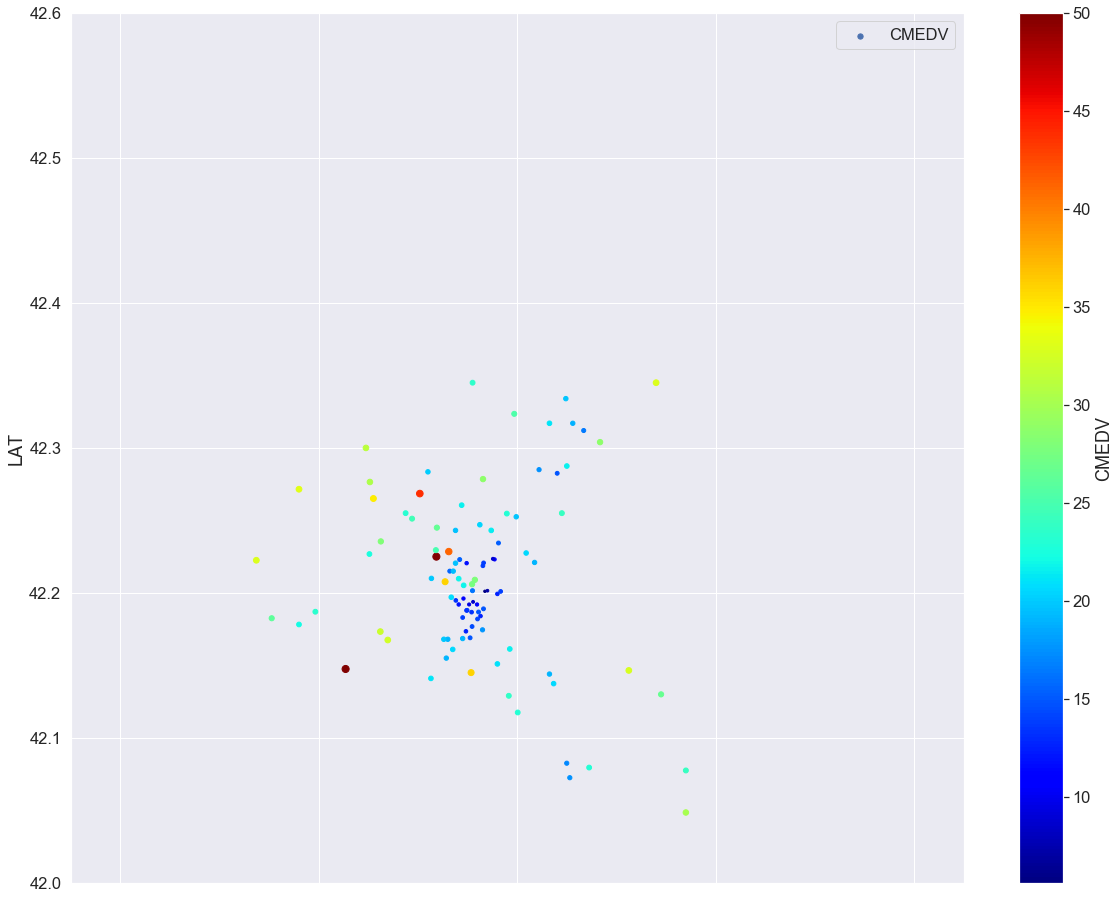

In [37]:
axes = X_test.plot(kind="scatter", x="LON", y="LAT",
    s=X_test['CMEDV'], label="CMEDV",
    c="CMEDV", cmap=plt.get_cmap("jet"),
    colorbar=True, alpha=1.0, figsize=(20,16),
)
axes.set_xlim([lon_min, lon_max])
axes.set_ylim([lat_min, lat_max])
plt.legend()

fig = plt.gcf()
plt.show()
fig.savefig('CMEDV_map.png', transparent=True)

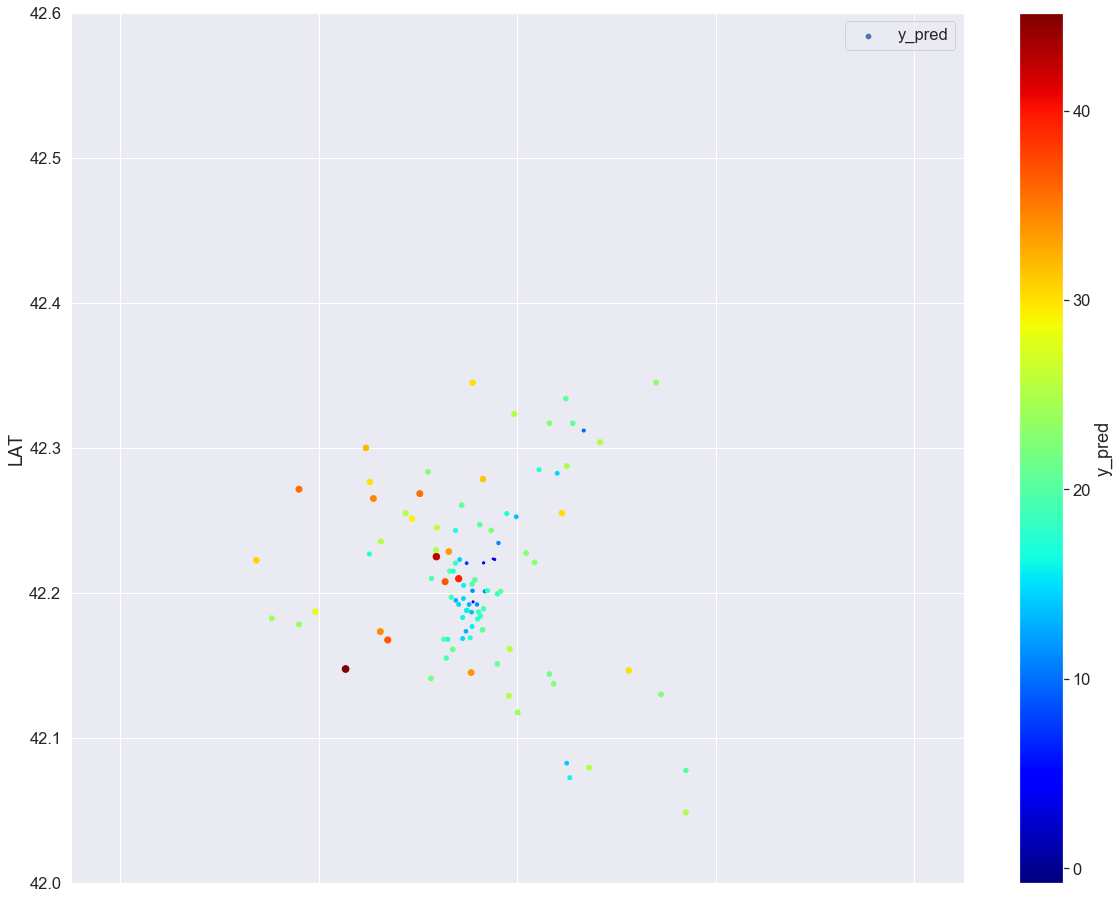

In [38]:
axes = X_test.plot(kind="scatter", x="LON", y="LAT",
    s=X_test['y_pred'], label="y_pred",
    c="y_pred", cmap=plt.get_cmap("jet"),
    colorbar=True, alpha=1.0, figsize=(20,16),
)
axes.set_xlim([lon_min, lon_max])
axes.set_ylim([lat_min, lat_max])
plt.legend()

fig = plt.gcf()
plt.show()
fig.savefig('pred_map.png', transparent=True)

-----

- Basemap 라이브러리를 활용해, 보스턴의 지도를 housing 데이터에 맞게 그려줍니다.
- 아래 코드 실행을 위해, anaconda prompt 혹은 터미널(cmd)에서 아래와 같은 패키지들을 설치해 줍니다.
    - (env_name) `conda install -c conda-forge basemap`
    - (env_name) `conda install -c conda-forge basemap-data-hires`

In [40]:
import os

# Windows :
# os.environ["PROJ_LIB"] = "C:\\Utilities\\Python\Anaconda\\Library\\share"

# Mac OS, Linux :
os.environ["PROJ_LIB"] = "/anaconda3/envs/{env_name}/share/proj"

from mpl_toolkits.basemap import Basemap

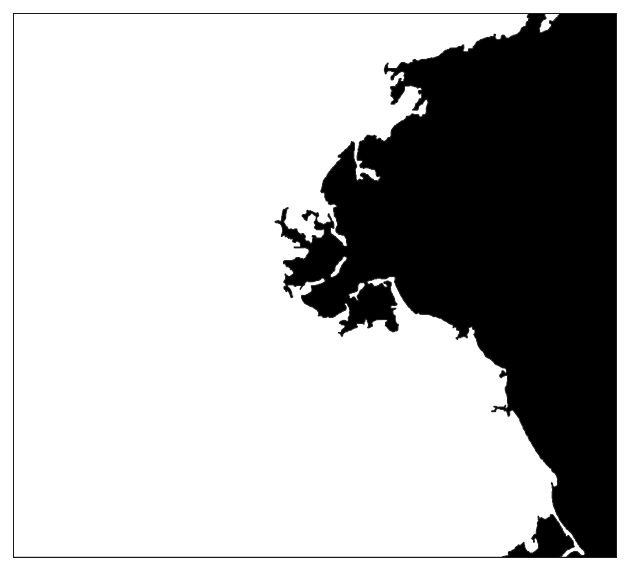

In [41]:
# 보스턴 지도 그리기
plt.figure(2, figsize=(15, 10))

m = Basemap(projection='merc',
            llcrnrlat=lat_min,
            urcrnrlat=lat_max,
            llcrnrlon=lon_min,
            urcrnrlon=lon_max,
            lat_ts=35,
            resolution='f')

m.fillcontinents(color='white',lake_color='black')
m.drawmapboundary(fill_color='black')
m.drawcoastlines()

# 맵 이미지 저장
fig = plt.gcf()
plt.show()
fig.savefig('map.png', transparent=True)

-----

- 집값 컬러맵 그래프와 지도 이미지를 겹쳐서 시각화합니다.

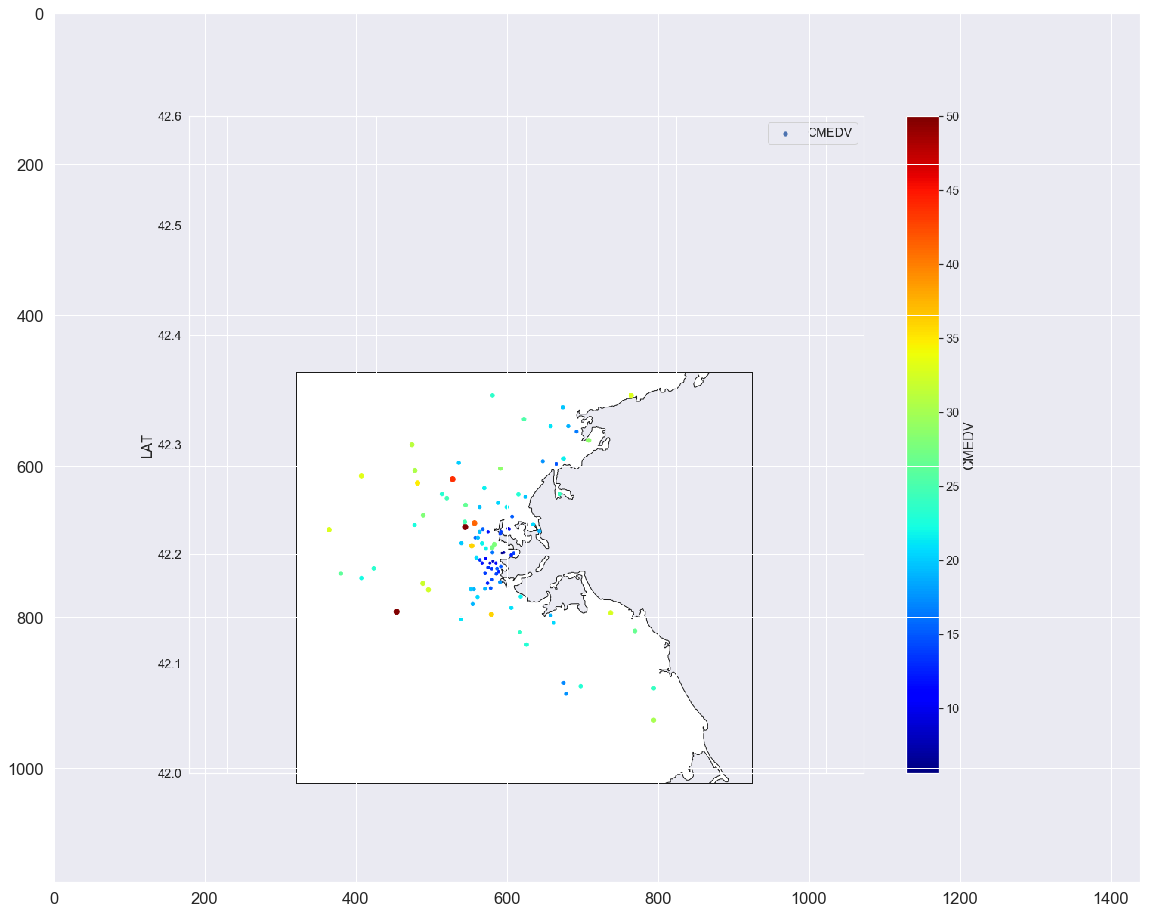

In [42]:
map_img = plt.imread('map.png')
pred_img = plt.imread('CMEDV_map.png')

x_offset, y_offset = 70, 390
coord_list = [0 + x_offset, 1080 + x_offset, 720 + y_offset, 0 + y_offset]
map_ax = plt.imshow(map_img, extent=coord_list)
pred_ax = plt.imshow(pred_img)

-----

# 회귀 분석으로 흉내내는 부동산 점쟁이

- 실제 price가 아닌, 예측된 price를 시각화 합니다.

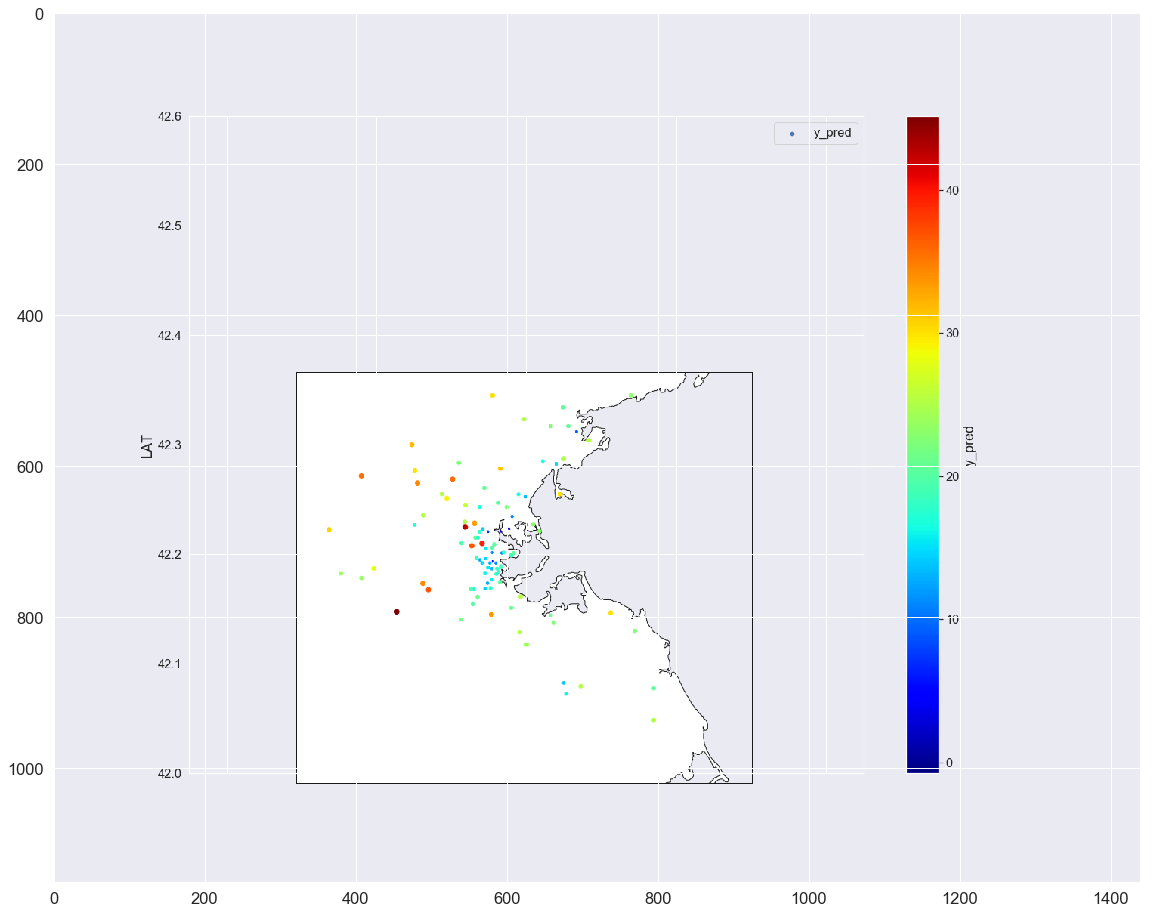

In [43]:
map_img = plt.imread('map.png')
pred_img = plt.imread('pred_map.png')

x_offset, y_offset = 70, 390
coord_list = [0 + x_offset, 1080 + x_offset, 720 + y_offset, 0 + y_offset]
map_ax = plt.imshow(map_img, extent=coord_list)
pred_ax = plt.imshow(pred_img)